# Feature: beam pattern taper correction (`removeTaper`)

This notebook covers the development of a method to determine (and correct for) the beam pattern taper that can be observed in multibeam data.

## Dependencies

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("..")) # so we can find didson.py, multibeam.py

import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Latin Modern Math']
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob 
from skimage.io import imread 


In [1]:
# test_image_list = glob('/home/pvt/Workspace/Data/HAUV/DIDSON/synth/dataset-1/*raw.png') 
test_image_list = glob('../data/dataset-1/*raw.png') # raw images only
print 'Test set size:',len(test_image_list)

# two sets of images observing open water (no objects) with window range from 2.25 to 11.25m (9m window)
bg_image_list_1 = glob('../data/dataset-2/*raw.png') # window set to 2.25m to 11.25m
print 'Background set 1 size:', len(bg_image_list_1)
bg_image_list_2 = glob('../data/dataset-3/*raw.png') # 
print 'Background set 2 size:',len(bg_image_list_2)

NameError: name 'glob' is not defined

In [7]:
from sonar import Sonar
from didson import Didson

didson = Didson();
didson.loadConfig('../data/DIDSON/didson.json')
# print 'Beams:',didson.num_beams
# print 'Range bins:',didson.num_bins
print 'Pings are',didson.num_beams,'beams by',didson.num_bins, 'bins'
print 'Field of view:', didson.fov
print 'Range:', didson.min_range, ' - ', didson.max_range, 'm.'
print 'Noise:', didson.noise


Resolution
Desired: 0.02 , x: 0.0199847165996 , y: 0.0200030206842
Resolution
Desired: 0.02 , x: 0.0199794887389 , y: 0.01998400879
Pings are 96 beams by 512 bins
Field of view: 0.502654824574
Range: 2.25  -  11.25 m.
Noise: 0.002


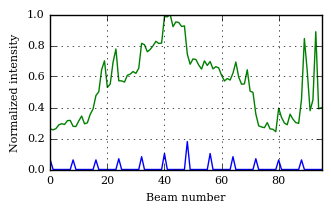

1.0
0.0962243596556


In [8]:
psf = didson.psf[0,:]
plt.figure(figsize=(3.5,2))
plt.plot(psf)
plt.plot(didson.taper)
plt.grid()
plt.xlabel('Beam number')
plt.ylabel('Normalized intensity')
plt.rc('font', size=8)
plt.xlim([0, 95])
plt.savefig('didson_psf_taper.eps',dpi=600,bbox_inches='tight',transparent=True,pad_inches=0.05)
plt.show()
print np.sum(psf)
print np.sum(psf**2)


## 1. Taper correction

This function computes the beam pattern taper from a set of scans (after deconvolving them).

In [9]:
def computeBPTaper(image_list, sonar,deconv=True):
    N = len(image_list)
    taper = np.zeros(sonar.num_beams, dtype = np.float64)
    for i in range(0,N):
        ping = imread(image_list[i],as_grey=True)
        ping = ping.astype(np.float64)
#         print 'ping',i
#         print '    range:',np.amin(ping[:]),'-',np.amax(ping[:])
#         print '    mean:', np.mean(ping[:])
#         print '    var:',np.var(ping[:])
        
        # deconvolve first
        if(deconv):
            ping = sonar.deconvolve(ping) 
        
        taper += np.sum(ping, axis = 0)
        
    taper/=(N+0.0)
    taper/=np.amax(taper)
    
    return taper.astype(dtype=ping.dtype)

Test the function on the background image sets.

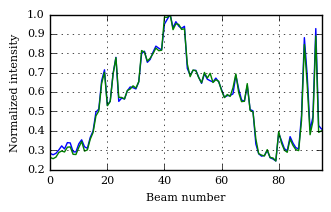

In [18]:
tp1 = computeBPTaper(bg_image_list_1, didson)
tp2 = computeBPTaper(bg_image_list_2, didson)

plt.figure(figsize=(3.5,2))
plt.plot(range(0,didson.num_beams),tp1)
plt.plot(range(0,didson.num_beams),tp2)
plt.grid()
plt.xlabel('Beam number')
plt.ylabel('Normalized intensity')
plt.rc('font', size=8)
# plt.title('Normalized beam pattern taper')
# plt.legend(['Set 1','Set 2'],loc=2) # top left
plt.xlim([0, 95])
plt.savefig('taper_data.eps',dpi=600,bbox_inches='tight',transparent=True,pad_inches=0.05)
plt.show()

We can now create a function that removes the taper from a given ping.

In [13]:
def removeBPTaper(ping, taper):
    taper = np.tile(taper, (ping.shape[0],1))
    ping2 = ping.astype(np.float64)
    ping2/=taper
    # renormalization
#     if ping2.max() > 1.0:
#         ping2 =(1.0/ping2.max())*ping2
#     else:
#         ping2 =(np.max(ping)/np.max(ping2))*ping2
    ping2 =(ping.max()/ping2.max())*ping2
    return ping2.astype(dtype=ping.dtype)

The following function computes the histogram of a ping - it is useful when trying to understand the effect of bem pattern taper on the intensity distribution of a ping.

In [21]:
def computeHist(ping):
    bins = np.arange(0,256)
    h = np.histogram(ping, bins)
    return (bins, (h[0]+0.0)/np.sum(h[0])) 

### Test image

This block retrieves a random image from one of the sets, and corrects for impulse response and beam pattern taper. The two versions of the image (before and after correction) are presented, as are the corresponding histograms.

selecting image 0
Beams: 96
Range bins: 512
Field of view: 0.502654824574
Range: 2.25  -  11.25 m.
Noise: 0.01


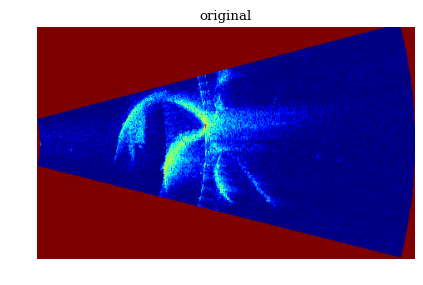

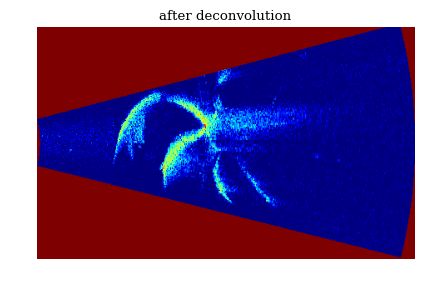

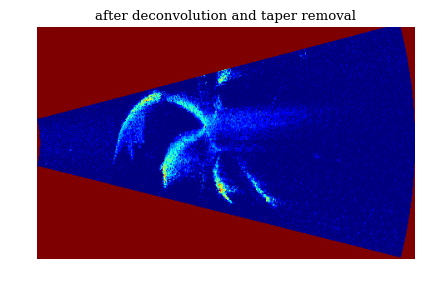

In [30]:
# image_list = glob('/home/pvt/Workspace/rpl/project-hauv/2017-07-31.00_reprocess/pings/raw/*.png') 
image_list = glob('../data/dataset-1/*raw.png') 
# cfg_list = glob('/home/pvt/Workspace/rpl/project-hauv/2017-08-01.00_reprocess/pings/raw/*.json')

idx = np.random.randint(0,len(image_list))

print 'selecting image',idx
# didson.loadConfig(cfg_list[idx]) 

print 'Beams:',didson.num_beams
print 'Range bins:',didson.num_bins
print 'Field of view:', didson.fov
print 'Range:', didson.min_range, ' - ', didson.max_range, 'm.'
print 'Noise:', didson.noise

ping0 = imread(image_list[idx],as_grey=True)
(b, h0) = computeHist(ping0)

ping1 = didson.deconvolve(ping0)
# ping1[ping1<0]=0
# ping1*=(ping0.max()+0.0)/ping1.max()
# ping1*=(np.sum(ping0[:])+0.0)/np.sum(ping1[:])
(b, h1) = computeHist(ping1)

ping2 = removeBPTaper(ping1, tp_020)
(b, h2) = computeHist(ping2)

colormap='gray'
colormap='jet'
fs = (5,3)
bg_value = 255.0

plt.figure(figsize=fs)
plt.imshow(didson.toCart(ping0,width=320,bg=255.0).transpose(),vmin=0,vmax=255,cmap=colormap)
plt.title('original')
plt.axis('off')
plt.savefig("ping.png",transparent=True,pad_inches=0.0)

plt.figure(figsize=fs)
plt.imshow(didson.toCart(ping1,width=320,bg=255.0).transpose(),vmin=0,vmax=255,cmap=colormap)
plt.title('after deconvolution')
plt.axis('off')
plt.savefig("ping_deconv.png",transparent=True,pad_inches=0.0)

plt.figure(figsize=fs)
plt.imshow(didson.toCart(ping2,width=320,bg=255.0).transpose(),vmin=0,vmax=255,cmap=colormap)
plt.title('after deconvolution and taper removal')
plt.axis('off')
plt.savefig("ping_deconv_taper.png",transparent=True,pad_inches=0.0)
